In [384]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import emnist


In [112]:
def sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))
def ReLU(z):
        return np.maximum(0,z)
def d_ReLU(z):
        return np.where(z > 0, 1, 0)
def Softmax(z):
        exp_vals = np.exp(z)
        return exp_vals / np.sum(exp_vals)
def d_Softmax(z):
        s = Softmax(z)
        return s * (1 - s)
def d_sigmoid(x):
        sig = sigmoid(x)
        return sig * (1.0 - sig)

Forma de los datos de entrenamiento: (60000, 28, 28)
Forma de los datos de prueba: (10000, 28, 28)
(28, 28)
Etiqueta correspondiente: 6
Dimensiones y tipo de dato de cada prueba: (28, 28) <class 'numpy.ndarray'>


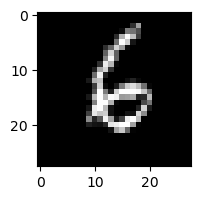

In [113]:


# Cargar la base de datos MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Imprimir la forma de los conjuntos de datos
print("Forma de los datos de entrenamiento:", x_train.shape)  # (60000, 28, 28)
print("Forma de los datos de prueba:", x_test.shape)  # (10000, 28, 28)
tst = 2000
# Ejemplo de acceso a los datos de entrenamiento
#primer_ejemplo = x_train[0]
plt.figure(figsize=(2, 2))
plt.imshow(x_test[tst]*(1/255.0),cmap='gray')
print(x_test[0].shape)
primer_etiqueta = y_test[tst]
print("Etiqueta correspondiente:", primer_etiqueta)
print("Dimensiones y tipo de dato de cada prueba:",x_train[0].shape,type(x_train[0]))

In [114]:
x_train_vectorizado = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test_vectorizado = x_test.reshape(x_test.shape[0], -1) / 255.0
# Imprimir la forma de los datos vectorizados
print("Forma de los datos de entrenamiento vectorizados:", x_train_vectorizado.shape)
print("Forma de los datos de entrenamiento vectorizados:", x_test_vectorizado.shape)



Forma de los datos de entrenamiento vectorizados: (60000, 784)
Forma de los datos de entrenamiento vectorizados: (10000, 784)


In [357]:
class My_Network(object):
    def __init__(self, sizes, X_train, Y_train, eta):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.normal(0, 1, (y, 1)) for y in sizes[1:]]
        self.weights = [np.random.normal(0, np.sqrt(1 / x), (y, x)) for x, y in zip(sizes[:-1], sizes[1:])]
        self.X_train = X_train
        self.Y_train = Y_train
        self.eta = eta

    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
        
    def ReLU(self, z):
        return np.maximum(0, z)

    def d_ReLU(self, z):
        return np.where(z > 0, 1, 0)
    
    def Softmax(self, z):
        exp_vals = np.exp(z)
        return exp_vals / np.sum(exp_vals)

    def d_Softmax(self, z):
        s = self.Softmax(z)
        return s * (1 - s)

    def d_sigmoid(self, x):
        sig = self.sigmoid(x)
        return sig * (1.0 - sig)
    
    def derivada_costo(self, a, y):
        return (a - y)

    def BackPropagation(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        x1 = np.reshape(x, (x.shape[0], 1))
        activacion = x1
        activaciones = [x1]

        zs = []

        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            z = np.dot(w, activacion) + b
            zs.append(z)
            activacion = self.ReLU(z)
            activaciones.append(activacion)

        z = np.dot(self.weights[-1], activaciones[-1]) + self.biases[-1]
        zs.append(z)
        activacion = self.Softmax(z)
        activaciones.append(activacion)

        vec_y = np.zeros((10,1))
        vec_y[y] = 1
        
        #print(activaciones[-1].shape,vec_y.shape)
        delta = self.derivada_costo(activaciones[-1], vec_y) * self.d_Softmax(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activaciones[-2].T)

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.d_ReLU(z)
            delta = np.dot(self.weights[-l + 1].T, delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activaciones[-l - 1].T)
        
        return (nabla_b, nabla_w)

    def train(self, epochs, batch_size):
        for epoch in range(epochs):
            data = list(zip(self.X_train, self.Y_train))
            np.random.shuffle(data)
            mini_batches = [data[k:k + batch_size] for k in range(0, len(data), batch_size)]
            
            for mini_batch in mini_batches:
                nabla_b = [np.zeros(b.shape) for b in self.biases]
                nabla_w = [np.zeros(w.shape) for w in self.weights]
                for x, y in mini_batch:
                    delta_nabla_b, delta_nabla_w = self.BackPropagation(x, y)
                    nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
                    nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

                self.weights = [w - (self.eta / len(mini_batch)) * nw 
                                for w, nw in zip(self.weights, nabla_w)]
                self.biases = [b - (self.eta / len(mini_batch)) * nb 
                               for b, nb in zip(self.biases, nabla_b)]

    def predict(self, X):
        x1 = np.reshape(X, (X.shape[0], 1))
        activations = x1
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            #print(b.shape,w.shape)
            z = np.dot(w, activations) + b
            #print(z)
            activations = self.ReLU(z)

        z = np.dot(self.weights[-1],activations)+self.biases[-1]
        activations = Softmax(z)

       
        return activations

In [358]:
# Crear una instancia de la red neuronal
network = My_Network(sizes=[784,30, 10],X_train= x_train_vectorizado,Y_train= y_train, eta=0.1)
# Entrenar la red neuronal
network.train(epochs=20, batch_size=32)



2


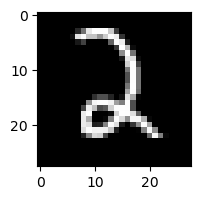

In [381]:
num_test = int(np.random.uniform(0,9999))
plt.figure(figsize=(2, 2))
plt.imshow(x_test[num_test]/255.0, cmap='gray')
res = np.argmax(network.predict(x_test_vectorizado[num_test]))
print(res)

In [387]:
aciertos = 0
for i in range(len(y_test)):
    if np.argmax(network.predict(x_test_vectorizado[i])) == y_test[i]:
        aciertos += 1
    else:
        aciertos = aciertos
    
print("La precision es de :",aciertos)

La precision es de : 9503


### AHORA USANDO LETRAS EN LUGAR DE DIGITOS